# <center>PRUEBA DE CONOCIMIENTOS SUNNYAPP</center>

Importamos las librerias necearias:

In [1]:
import pandas as pd
from numpy import *
import math
from threading import Thread

## Parte 1

En el hilo principal implementar un codigo que importe los datos pasados por los ingenieros

### Desarrollo

Creamos una funcion para leer el archivo

In [2]:
def read_data_file(file_name):
    return pd.read_csv(file_name, sep=",")

Procedemos a verificar la funcion creada txt:

In [3]:
dt = read_data_file('datos.txt')

Verificamos el 'dateset' importado

In [4]:
dt

,t,theta,v,w
0,1,0,10,0.1
1,2,10,8,0.5
2,3,20,7,0.5
3,4,30,6,0.6
4,5,40,5,0.7
5,6,50,8,0.4
6,7,60,9,0.4
7,8,70,10,0.3
8,9,80,12,0.2
9,10,90,13,0.1


Mas adelante se reutilizara este codigo

## Parte 2

En un hilo secundario, ejecutar las operaciones matemáticas necesarias (ver figura a continuación) para obtener la velocidad de las llantas.

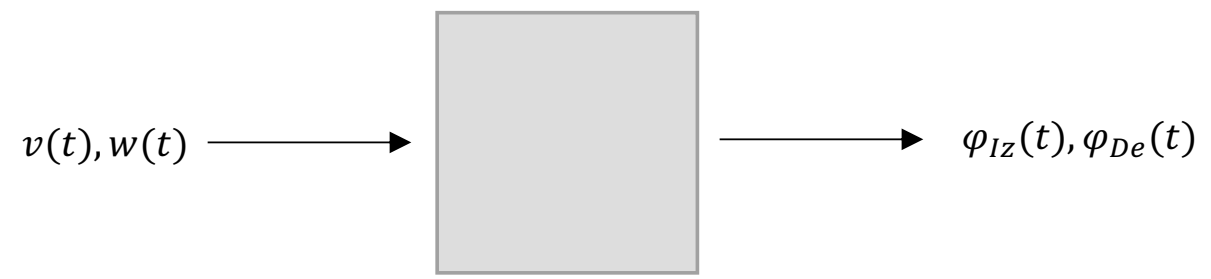

### Desarrollo

1. Primero debe tomar las variables $v(t)$, $w(t)$ y transformalas a las variables de velocidad cartesianas $x'(t)$, $y'(t)$ y $\theta'(t)$. Esto lo puede hacer a partir de la siguiente operación matricial:

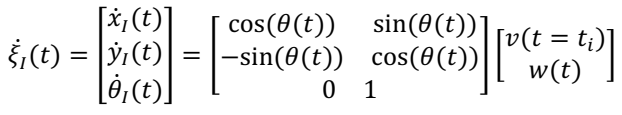

Creamos la funcion para calcular vector de movimiento en el marco global:

In [5]:
def speed_vector(theta, v, w):
    r=array([
        [cos(theta), sin(theta)],
        [-sin(theta), cos(theta)], 
        [0, 1]])
    s=array([v, w])
    return dot(r, s)
    

Probamos la funcion con la primera fila de del dataset:

In [6]:
xip_I_test=speed_vector(dt.iloc[0]['theta'], dt.iloc[0]['v'], dt.iloc[0]['w'])
xip_I_test

array([10. ,  0.1,  0.1])

2. Una vez obtenido $\xi'_I$ el vector de movimiento en el marco global, debe transformarlo al vector en marco local con:

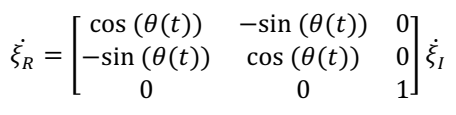

Creamos la funcion para realizar la transformación:

In [7]:
def local_frame_transform(theta, xip_I):
    r=array([
        [cos(theta), -sin(theta), 0],
        [-sin(theta), cos(theta), 0],
        [0, 0, 1]])
    return dot(r, xip_I)

Probamos la funcion:

In [8]:
xip_R_test=local_frame_transform(dt.iloc[0]['theta'], xip_I_test)
xip_R_test

array([10. ,  0.1,  0.1])

3. Por ultimo, se debe tomar este vector resultado y convertirlo en nuestro vector deseado $\phi_{Iz}(t)$, $\phi_{De}(t)$

Esta conversión se da a partir de la definición:

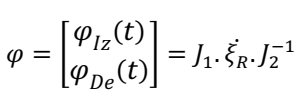

Donde $J_1$ es la matriz Jacobiano que describe que describe las llantas del robot:

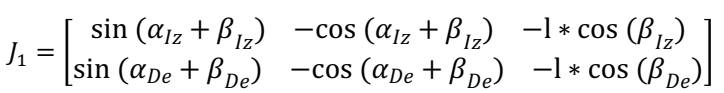

Para este ejercicio, asuma:

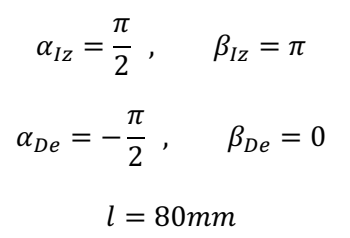

Y donde $J_{2}^{-1}$ se define como:

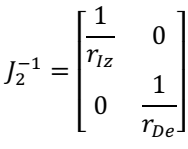

Donde:

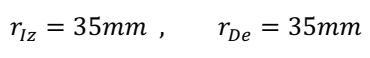

Declaramos las constantes:

In [9]:
alpha_Iz=math.pi/2
alpha_De=math.pi/2
betha_Iz=math.pi
betha_De=0
l=80

r_Iz=r_De=35

J_1=array([
    [sin(alpha_Iz+betha_Iz), -cos(alpha_Iz+betha_Iz), -l*cos(betha_Iz)],
    [sin(alpha_De+betha_De), -cos(alpha_De+betha_De), -l*cos(betha_De)]])

J_2_1=array([
    [(1/r_Iz), 0],
    [0, (1/r_De)]])

Definimos la funcion para el vector deseado:

In [10]:
def result_vector(xip_R, j1, j2_1):
    return  dot(dot(j1, xip_R), j2_1)

In [11]:
result_vector(xip_R_test, J_1, J_2_1)

array([-0.05714286,  0.05714286])

## Parte 3

En el hilo principal exportar el resultado de las transformaciones.

Procedemos a crear los hilos:

In [12]:
class CustomThread(Thread):
    def __init__(self, group=None, target=None, name=None,
                 args=(), kwargs={}, Verbose=None):
        Thread.__init__(self, group, target, name, args, kwargs)
        self._return = None
 
    def run(self):
        if self._target is not None:
            self._return = self._target(*self._args, **self._kwargs)
             
    def join(self, *args):
        Thread.join(self, *args)
        return self._return

In [13]:
thread_read_file = CustomThread(target=read_data_file, args=('datos.txt',))
thread_read_file.start()
data = thread_read_file.join()
data

,t,theta,v,w
0,1,0,10,0.1
1,2,10,8,0.5
2,3,20,7,0.5
3,4,30,6,0.6
4,5,40,5,0.7
5,6,50,8,0.4
6,7,60,9,0.4
7,8,70,10,0.3
8,9,80,12,0.2
9,10,90,13,0.1


In [14]:
def calculations(dx):
    dr = pd.DataFrame(columns = ['tiempo', 'Velocidad Angular rueda izquierda', 'Velocidad Angular rueda derecha'])
    for (idx, row) in dx.iterrows():
        xip_I_row=speed_vector(row.loc['theta'], row.loc['v'], row.loc['w'])
        xip_R_row=local_frame_transform(row.loc['theta'], xip_I_row)
        result_vector_row=result_vector(xip_R_row, J_1, J_2_1)
        dr.loc[idx]= [dx.iloc[idx]['t'], result_vector_row[0],result_vector_row[1]]
    return dr

In [15]:
thread_result = CustomThread(target=calculations, args=(data,))
thread_result.start()
result_data_frame = thread_result.join()
result_data_frame

,tiempo,Velocidad Angular rueda izquierda,Velocidad Angular rueda derecha
0,1.0,-0.057143,0.057143
1,2.0,0.914286,-0.914286
2,3.0,0.942857,-0.942857
3,4.0,1.200000,-1.200000
4,5.0,1.457143,-1.457143
5,6.0,0.685714,-0.685714
6,7.0,0.657143,-0.657143
7,8.0,0.400000,-0.400000
8,9.0,0.114286,-0.114286
9,10.0,-0.142857,0.142857


Procedemos a registrar en  un archivo:

In [16]:
result_data_frame.to_csv('resultado.txt', sep=',', index=False)

## Parte 4

Implemntar graficos:

In [17]:
import matplotlib.pyplot as plt

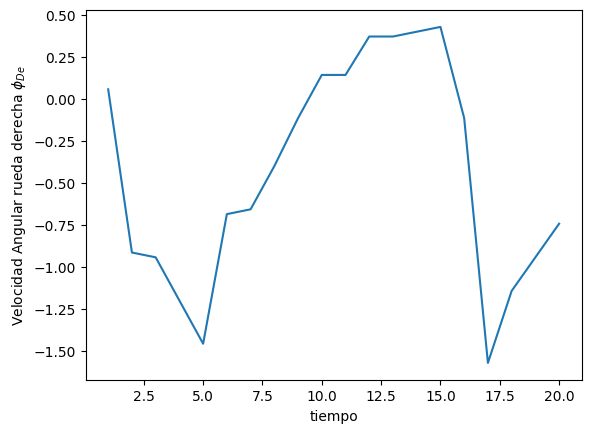

In [18]:
plt.xlabel("tiempo")
plt.ylabel(r"Velocidad Angular rueda derecha $\phi_{De}$")
plt.plot(result_data_frame["tiempo"], result_data_frame["Velocidad Angular rueda derecha"])

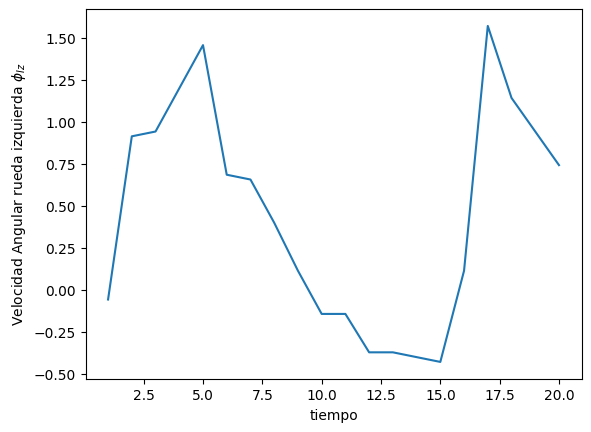

In [19]:
plt.xlabel("tiempo")
plt.ylabel(r"Velocidad Angular rueda izquierda $\phi_{Iz}$")
plt.plot(result_data_frame["tiempo"], result_data_frame["Velocidad Angular rueda izquierda"])